## INDENG 242A Project
Jingyan Li
### (a) Data Preparation

In [6]:
import pandas as pd
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

df = pd.read_csv('in_vehicle_coupon_selection.csv', header=0)
print(df.info())
print(df.describe())

# Drop the 'direction_opp' column
if 'direction_opp' in df.columns:
    df = df.drop(columns='direction_opp')

# Duplicate row analysis and handling
dup_row = df.duplicated(
    subset=[
        'destination', 'passanger', 'weather', 'temperature', 'time', 'coupon',
        'expiration', 'gender', 'age', 'maritalStatus', 'has_children', 'education',
        'occupation', 'income', 'Bar', 'CoffeeHouse', 'CarryAway',
        'RestaurantLessThan20', 'Restaurant20To50',
        'toCoupon_GEQ15min', 'toCoupon_GEQ25min', 'direction_same', 'Y'
    ],
    keep=False
)
print('Number of duplicate rows:', dup_row.sum())

# Remove duplicates
df = df.drop_duplicates(keep='first')

# Missing value
col_nan = df.isnull().sum()
print('Total number of missing values:', col_nan.sum(),
      '\nMissing values by column:\n', col_nan[col_nan != 0])
"""
# Drop rows containing missing values
df = df.dropna()
col_nan = df.isnull().sum()
print('Total number of missing values:', col_nan.sum(),
      '\nMissing values by column:\n', col_nan[col_nan != 0])
"""
# Split
df.to_csv('cs_cleaned.csv', index=False)
df_train, df_test = train_test_split(
    df, test_size=0.2, random_state=42, shuffle=True
)

df_train.to_csv('cs_train.csv', index=False)
df_test.to_csv('cs_test.csv', index=False)

df_train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12684 entries, 0 to 12683
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   destination           12684 non-null  object
 1   passanger             12684 non-null  object
 2   weather               12684 non-null  object
 3   temperature           12684 non-null  int64 
 4   time                  12684 non-null  object
 5   coupon                12684 non-null  object
 6   expiration            12684 non-null  object
 7   gender                12684 non-null  object
 8   age                   12684 non-null  object
 9   maritalStatus         12684 non-null  object
 10  has_children          12684 non-null  int64 
 11  education             12684 non-null  object
 12  occupation            12684 non-null  object
 13  income                12684 non-null  object
 14  car                   108 non-null    object
 15  Bar                   12577 non-null

,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,...,Bar,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,Y
2874,No Urgent Place,Friend(s),Sunny,80,10AM,Carry out & Take away,2h,Female,36,Married partner,...,NaN,1~3,4~8,1~3,1~3,1,1,0,0,0
11153,No Urgent Place,Alone,Rainy,55,10AM,Bar,1d,Female,41,Married partner,...,less1,4~8,gt8,1~3,less1,1,1,0,0,0
11863,Work,Alone,Rainy,55,7AM,Carry out & Take away,1d,Male,26,Unmarried partner,...,less1,NaN,1~3,never,never,1,0,0,0,0
8943,Home,Kid(s),Sunny,80,6PM,Restaurant(20-50),2h,Female,31,Married partner,...,never,4~8,4~8,less1,less1,1,1,0,1,1
3058,No Urgent Place,Kid(s),Sunny,80,2PM,Restaurant(<20),1d,Female,41,Married partner,...,less1,gt8,4~8,gt8,less1,1,0,0,0,1


In [5]:
numeric_features = [
    "has_children",
    "toCoupon_GEQ15min",
    "toCoupon_GEQ25min",
    "direction_same",
]

categorical_features = [
    "temperature",
    "destination",
    "passanger",
    "weather",
    "time",
    "coupon",
    "expiration",
    "gender",
    "age",
    "maritalStatus",
    "education",
    "occupation",
    "income",
    "Bar",
    "CoffeeHouse",
    "CarryAway",
    "RestaurantLessThan20",
    "Restaurant20To50",
]

target_col = "Y"  # accept coupon (0/1)

### (b) Baseline Models

(i) Logistics regression

In [8]:
ohe = OneHotEncoder(drop="first", sparse_output=False, handle_unknown="ignore")

preprocess = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric_features),
        ("cat", ohe, categorical_features),
    ],
    remainder="drop",
)

X_train = preprocess.fit_transform(df_train[numeric_features + categorical_features])
X_test = preprocess.transform(df_test[numeric_features + categorical_features])

y_train = df_train[target_col].astype(int).values
y_test = df_test[target_col].astype(int).values

print("Train feature matrix shape:", X_train.shape)
print("Test feature matrix shape:", X_test.shape)

sk_logit = LogisticRegression(max_iter=5000)
sk_logit.fit(X_train, y_train)

y_pred_sklogit_train = sk_logit.predict(X_train)
y_pred_sklogit_test = sk_logit.predict(X_test)

print("Sklearn logistic train acc:", accuracy_score(y_train, y_pred_sklogit_train))
print("Sklearn logistic test acc:", accuracy_score(y_test, y_pred_sklogit_test))

Train feature matrix shape: (10088, 96)
Test feature matrix shape: (2522, 96)
Sklearn logistic train acc: 0.6947858842188739
Sklearn logistic test acc: 0.6819984139571769


Selected C: 1.1434512395228285
Selected lambda: 0.8745453810669777

Lambda vs CV Accuracy:
lambda=1.0000e-02 | mean acc=0.6871 | std=0.0139
lambda=1.2505e-02 | mean acc=0.6870 | std=0.0139
lambda=1.5638e-02 | mean acc=0.6871 | std=0.0138
lambda=1.9555e-02 | mean acc=0.6870 | std=0.0140
lambda=2.4454e-02 | mean acc=0.6869 | std=0.0140
lambda=3.0581e-02 | mean acc=0.6870 | std=0.0140
lambda=3.8241e-02 | mean acc=0.6869 | std=0.0139
lambda=4.7822e-02 | mean acc=0.6869 | std=0.0139
lambda=5.9802e-02 | mean acc=0.6871 | std=0.0141
lambda=7.4783e-02 | mean acc=0.6871 | std=0.0141
lambda=9.3517e-02 | mean acc=0.6869 | std=0.0139
lambda=1.1694e-01 | mean acc=0.6874 | std=0.0141
lambda=1.4624e-01 | mean acc=0.6873 | std=0.0144
lambda=1.8288e-01 | mean acc=0.6873 | std=0.0145
lambda=2.2869e-01 | mean acc=0.6872 | std=0.0148
lambda=2.8598e-01 | mean acc=0.6873 | std=0.0148
lambda=3.5762e-01 | mean acc=0.6871 | std=0.0145
lambda=4.4721e-01 | mean acc=0.6874 | std=0.0147
lambda=5.5925e-01 | mean ac

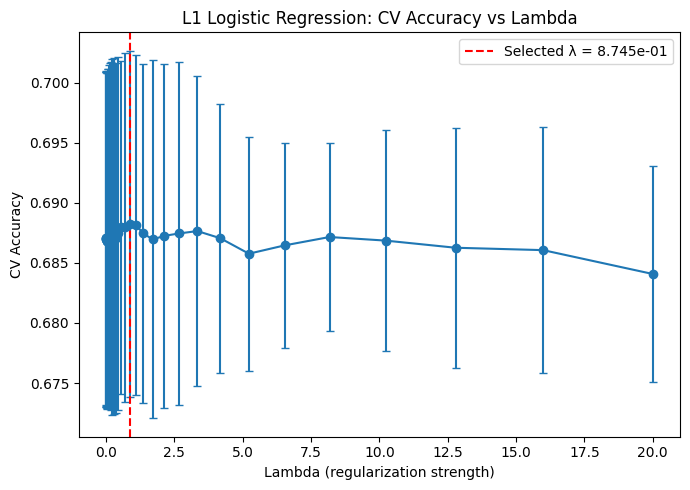

In [48]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score, roc_auc_score

lambdas_grid = np.logspace(-2, np.log10(20), 35)   # 0.01 to 20
Cs_grid = 1.0 / lambdas_grid

lasso_logit_cv = LogisticRegressionCV(
    Cs=Cs_grid,
    cv=5,
    penalty="l1",
    solver="saga",
    scoring="accuracy",
    max_iter=20000,
    n_jobs=-1,
    refit=True,
)


lasso_logit_cv.fit(X_train, y_train)

# Selected lambda
best_C = lasso_logit_cv.C_[0]
best_lambda = 1.0 / best_C
print("Selected C:", best_C)
print("Selected lambda:", best_lambda)

# CV accuracy for each lambda
scores = lasso_logit_cv.scores_[1]    # positive class = 1
mean_acc = scores.mean(axis=0)
std_acc = scores.std(axis=0)

lambdas = 1.0 / lasso_logit_cv.Cs_

print("\nLambda vs CV Accuracy:")
for lam, acc, sd in zip(lambdas, mean_acc, std_acc):
    print(f"lambda={lam:10.4e} | mean acc={acc:.4f} | std={sd:.4f}")

# Test performance
y_pred_lasso_test = lasso_logit_cv.predict(X_test)
y_prob_lasso_test = lasso_logit_cv.predict_proba(X_test)[:, 1]

print("\nL1-logit test acc:", accuracy_score(y_test, y_pred_lasso_test))
print("L1-logit test AUC:", roc_auc_score(y_test, y_prob_lasso_test))

# Sparsity (feature selection effect)
coef = lasso_logit_cv.coef_.ravel()
feature_names = preprocess.get_feature_names_out()
nonzero_idx = coef != 0
zero_idx = coef == 0

# Selected features
print("\nSelected features (non-zero coefficients):")
for name, c in zip(feature_names[nonzero_idx], coef[nonzero_idx]):
    print(f"{name:60s}  coef={c:.4f}")

# Dropped features
print("\nDropped features (zero coefficients):")
for name in feature_names[zero_idx]:
    print(name)

print("\nSummary:")
print("Total features:", len(feature_names))
print("Non-zero coefficients:", nonzero_idx.sum())
print("Zero coefficients:", zero_idx.sum())

scores = lasso_logit_cv.scores_[1]   # positive class = 1
mean_acc = scores.mean(axis=0)
std_acc = scores.std(axis=0)

Cs = lasso_logit_cv.Cs_
lambdas = 1.0 / Cs
best_lambda = 1.0 / lasso_logit_cv.C_[0]

plt.figure(figsize=(7, 5))
plt.errorbar(
    lambdas,
    mean_acc,
    yerr=std_acc,
    fmt="o-",
    capsize=3,
)
plt.axvline(
    best_lambda,
    color="red",
    linestyle="--",
    label=f"Selected λ = {best_lambda:.3e}",
)
plt.xlabel("Lambda (regularization strength)")
plt.ylabel("CV Accuracy")
plt.title("L1 Logistic Regression: CV Accuracy vs Lambda")
plt.legend()
plt.tight_layout()
plt.show()

(ii) CART

Best ccp_alpha: 0.001
Best CV accuracy: 0.7015261751819152


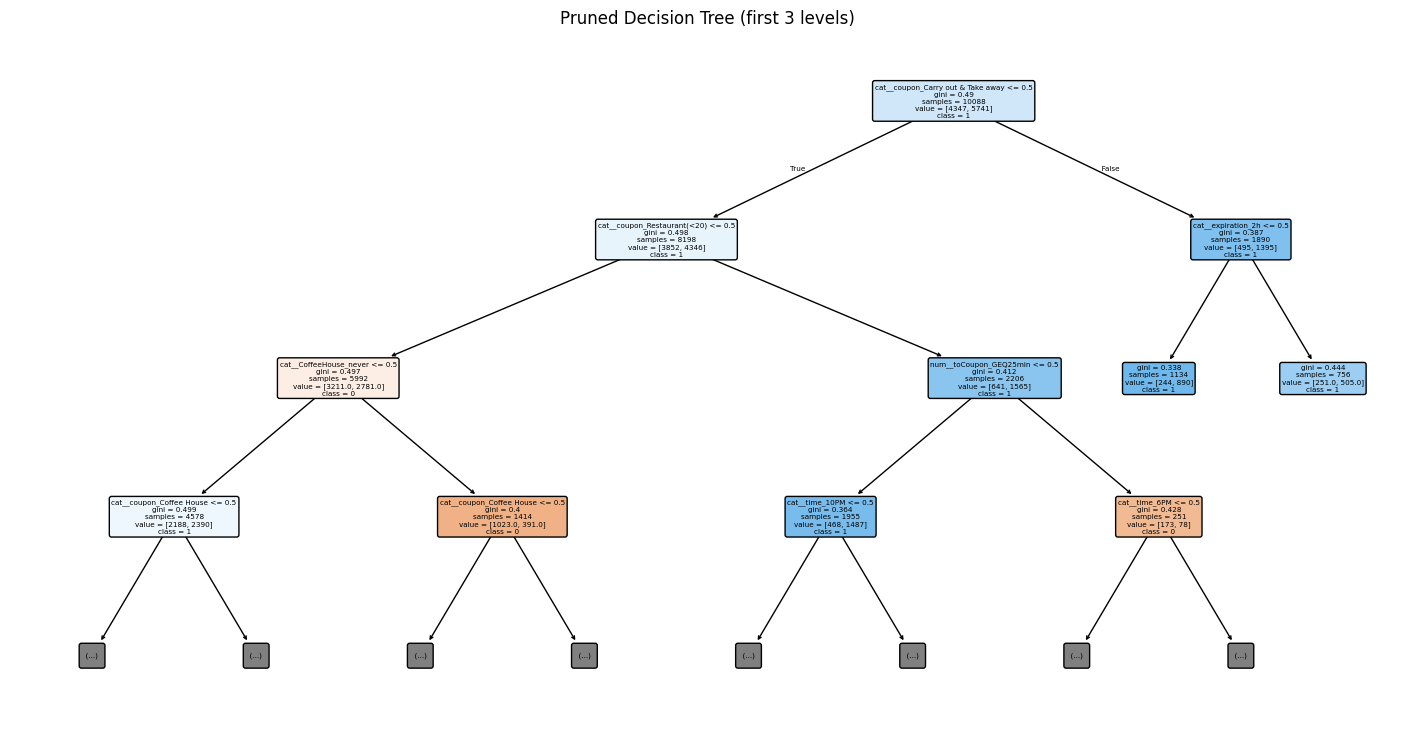

Pruned tree test acc: 0.6808088818398097


In [9]:
param_grid_tree = {"ccp_alpha": np.linspace(0.0, 0.02, 21)}
base_tree = DecisionTreeClassifier(random_state=0)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
grid_tree = GridSearchCV(
    estimator=base_tree,
    param_grid=param_grid_tree,
    scoring="accuracy",
    cv=cv,
    n_jobs=-1,
)

grid_tree.fit(X_train, y_train)

print("Best ccp_alpha:", grid_tree.best_params_["ccp_alpha"])
print("Best CV accuracy:", grid_tree.best_score_)

best_tree = grid_tree.best_estimator_

feature_names = preprocess.get_feature_names_out()

plt.figure(figsize=(18, 9))
plot_tree(
    best_tree,
    filled=True,
    max_depth=3,
    feature_names=feature_names,
    class_names=["0", "1"],
    rounded=True,
)
plt.title("Pruned Decision Tree (first 3 levels)")
plt.show()

y_pred_tree_test = best_tree.predict(X_test)
acc_test_tree = accuracy_score(y_test, y_pred_tree_test)
print("Pruned tree test acc:", acc_test_tree)

### (c) Ensemble Models
(i) Majority vote ensemble

In [50]:
pred_lasso_test = lasso_logit_cv.predict(X_test)
pred_tree_test = best_tree.predict(X_test)

# majority vote with 2 models:
# - if they agree -> that label
# - if they disagree -> tie-break by averaging predicted probabilities
proba_lasso_test = lasso_logit_cv.predict_proba(X_test)[:, 1]
proba_tree_test = best_tree.predict_proba(X_test)[:, 1]

avg_proba_test = 0.5 * (proba_lasso_test + proba_tree_test)
pred_ensemble_test = (avg_proba_test >= 0.5).astype(int)

acc_ensemble_test = accuracy_score(y_test, pred_ensemble_test)
print("Majority-vote ensemble test acc:", acc_ensemble_test)

print("Lasso logit test acc:", accuracy_score(y_test, pred_lasso_test))
print("CART test acc:", accuracy_score(y_test, pred_tree_test))

Majority-vote ensemble test acc: 0.7006344171292624
Lasso logit test acc: 0.6835844567803331
CART test acc: 0.6808088818398097


(ii) Bagging and Random Forest

In [11]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

bag_clf = BaggingClassifier(
    estimator=DecisionTreeClassifier(random_state=0),
    n_estimators=200,
    random_state=0,
    n_jobs=-1,
)
bag_clf.fit(X_train, y_train)

y_pred_bag = bag_clf.predict(X_test)
acc_bag = accuracy_score(y_test, y_pred_bag)
print("Bagging test acc:", acc_bag)

# Random Forest + CV
rf = RandomForestClassifier(
    random_state=0,
    n_estimators=300,
    n_jobs=-1,
)

param_grid_rf = {
    "max_features": ["sqrt", "log2", 0.3, 0.5, 0.7],
    "min_samples_leaf": [1, 3, 5],
}

grid_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid_rf,
    cv=cv,
    scoring="accuracy",
    n_jobs=-1,
)

grid_rf.fit(X_train, y_train)

print("Best RF params:", grid_rf.best_params_)
print("Best RF CV accuracy:", grid_rf.best_score_)

best_rf = grid_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test)
acc_rf = accuracy_score(y_test, y_pred_rf)
print("Random Forest test acc:", acc_rf)

Bagging test acc: 0.7498017446471055
Best RF params: {'max_features': 0.5, 'min_samples_leaf': 1}
Best RF CV accuracy: 0.7568381345284605
Random Forest test acc: 0.746629659000793


(iii) Gradient Boosting

Best GB params: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.8}
Best GB CV accuracy: 0.745240922918326
Gradient Boosting test acc: 0.7339413164155432

CV mean accuracy (fixed learning_rate & subsample):
param_max_depth            1         2         3
param_n_estimators                              
50                  0.667030  0.705095  0.715602
100                 0.677042  0.715008  0.727300
150                 0.680709  0.720163  0.733644
200                 0.681007  0.722443  0.737212
300                 0.682891  0.730472  0.745241


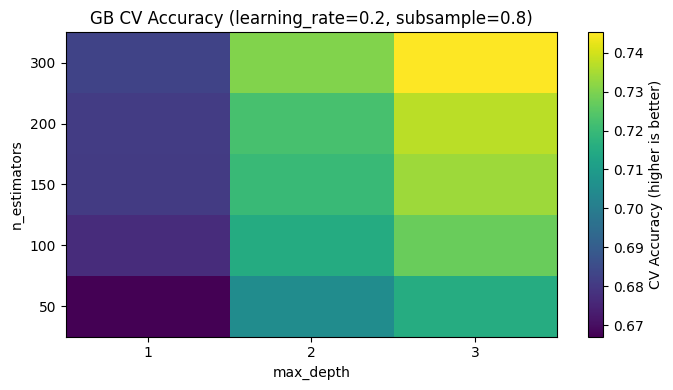

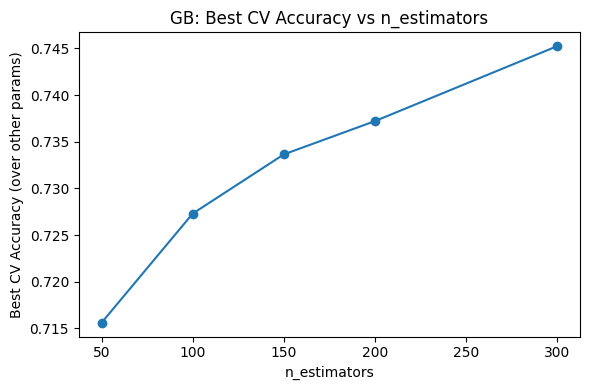

In [52]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

# Gradient Boosting CLASSIFIER + CV
gb = GradientBoostingClassifier(random_state=0)

param_grid_gb = {
    "n_estimators": [50, 100, 150, 200, 300],
    "learning_rate": [0.05, 0.1, 0.2],
    "max_depth": [1, 2, 3],          # depth of individual trees
    "subsample": [1.0, 0.8],         # optional stochastic boosting
}

grid_gb = GridSearchCV(
    estimator=gb,
    param_grid=param_grid_gb,
    cv=cv,
    scoring="accuracy",              # CV selects best by accuracy
    n_jobs=-1,
    return_train_score=True,
)

grid_gb.fit(X_train, y_train)

print("Best GB params:", grid_gb.best_params_)
print("Best GB CV accuracy:", grid_gb.best_score_)

best_gb = grid_gb.best_estimator_

# test performance
y_pred_gb_test = best_gb.predict(X_test)
acc_gb = accuracy_score(y_test, y_pred_gb_test)
print("Gradient Boosting test acc:", acc_gb)

# Performance curve from CV results
# Heatmap: n_estimators x max_depth at best learning_rate/subsample
cv_results_gb = pd.DataFrame(grid_gb.cv_results_)

best_lr = grid_gb.best_params_["learning_rate"]
best_sub = grid_gb.best_params_["subsample"]

subset = cv_results_gb[
    (cv_results_gb["param_learning_rate"] == best_lr) &
    (cv_results_gb["param_subsample"] == best_sub)
].copy()

pivot_acc = subset.pivot_table(
    index="param_n_estimators",
    columns="param_max_depth",
    values="mean_test_score",
    aggfunc="mean",
).sort_index()

print("\nCV mean accuracy (fixed learning_rate & subsample):")
print(pivot_acc)

plt.figure(figsize=(7, 4))
plt.imshow(pivot_acc.values, origin="lower", aspect="auto")
plt.colorbar(label="CV Accuracy (higher is better)")
plt.xticks(range(len(pivot_acc.columns)), pivot_acc.columns)
plt.yticks(range(len(pivot_acc.index)), pivot_acc.index)
plt.xlabel("max_depth")
plt.ylabel("n_estimators")
plt.title(f"GB CV Accuracy (learning_rate={best_lr}, subsample={best_sub})")
plt.tight_layout()
plt.show()

# 1D curve: best CV accuracy vs n_estimators (after marginalizing other params)
curve = cv_results_gb.groupby("param_n_estimators")["mean_test_score"].max().sort_index()

plt.figure(figsize=(6, 4))
plt.plot(curve.index.astype(int), curve.values, marker="o")
plt.xlabel("n_estimators")
plt.ylabel("Best CV Accuracy (over other params)")
plt.title("GB: Best CV Accuracy vs n_estimators")
plt.tight_layout()
plt.show()

(iv) Performance table

In [54]:
def get_metrics(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    acc = (tp + tn) / (tp + tn + fp + fn)
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0.0
    return acc, tpr, fpr

rows = []

# 1) Sklearn Logit (unregularized)
acc, tpr, fpr = get_metrics(y_test, y_pred_sklogit_test)
rows.append(["Logistics Regression", acc, tpr, fpr])

# 2) Lasso Logistic Regression (CV)
y_pred_lasso_test = lasso_logit_cv.predict(X_test)
acc, tpr, fpr = get_metrics(y_test, y_pred_lasso_test)
rows.append(["Logistics Regression + Lasso", acc, tpr, fpr])

# 3) Pruned Decision Tree (CART)
acc, tpr, fpr = get_metrics(y_test, y_pred_tree_test)
rows.append(["CART", acc, tpr, fpr])

# 4) Majority Vote (Lasso Logit + Tree)
acc, tpr, fpr = get_metrics(y_test, pred_ensemble_test)
rows.append(["Majority Vote (Logit + CART)", acc, tpr, fpr])

# 5) Bagging
acc, tpr, fpr = get_metrics(y_test, y_pred_bag)
rows.append(["Bagging", acc, tpr, fpr])

# 6) Random Forest
acc, tpr, fpr = get_metrics(y_test, y_pred_rf)
rows.append(["Random Forest", acc, tpr, fpr])

# 7) Gradient Boosting (Classifier)
acc, tpr, fpr = get_metrics(y_test, y_pred_gb_test)
rows.append(["Gradient Boosting", acc, tpr, fpr])

perf_df = pd.DataFrame(rows, columns=["Model", "Accuracy", "TPR", "FPR"])
perf_df_sorted = perf_df.sort_values("Accuracy", ascending=False)
perf_df_sorted

,Model,Accuracy,TPR,FPR
4,Bagging,0.749802,0.814972,0.333635
5,Random Forest,0.746630,0.810734,0.335443
6,Gradient Boosting,0.733941,0.794492,0.343580
3,Majority Vote (Logit + CART),0.700634,0.798023,0.424051
1,Logistics Regression + Lasso,0.683584,0.773305,0.431284
0,Logistics Regression,0.681998,0.770480,0.431284
2,CART,0.680809,0.790960,0.460217


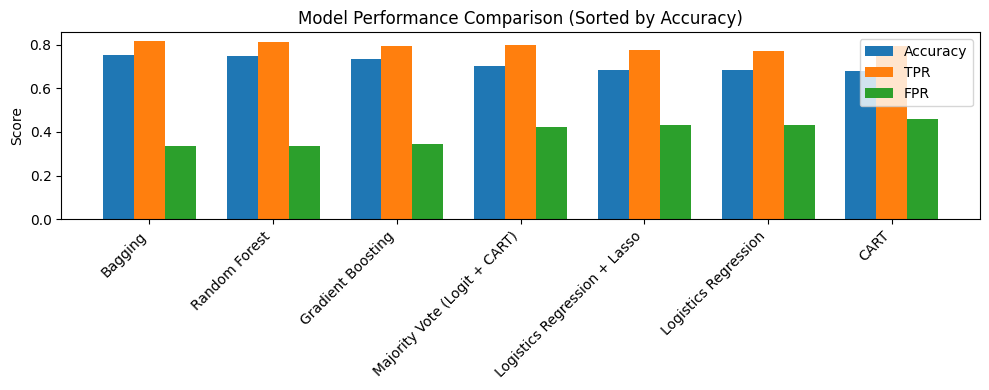

In [55]:
x = np.arange(len(perf_df_sorted))
width = 0.25

plt.figure(figsize=(10, 4))
plt.bar(x - width, perf_df_sorted["Accuracy"], width, label="Accuracy")
plt.bar(x, perf_df_sorted["TPR"], width, label="TPR")
plt.bar(x + width, perf_df_sorted["FPR"], width, label="FPR")

plt.xticks(x, perf_df_sorted["Model"], rotation=45, ha="right")
plt.ylabel("Score")
plt.title("Model Performance Comparison (Sorted by Accuracy)")
plt.legend()
plt.tight_layout()
plt.show()


### (d)
(i) Feature importance

Random Forest feature importance (top 20):
cat__coupon_Carry out & Take away    0.034601
cat__coupon_Restaurant(<20)          0.034140
cat__expiration_2h                   0.030371
cat__CoffeeHouse_never               0.029720
cat__coupon_Coffee House             0.025566
cat__Bar_never                       0.021680
num__toCoupon_GEQ15min               0.020321
cat__time_6PM                        0.018596
cat__destination_No Urgent Place     0.018228
cat__gender_Male                     0.017523
cat__Restaurant20To50_less1          0.017007
cat__CoffeeHouse_less1               0.016590
cat__CarryAway_4~8                   0.015367
cat__RestaurantLessThan20_4~8        0.015317
cat__education_Bachelors degree      0.015173
cat__passanger_Friend(s)             0.014717
num__toCoupon_GEQ25min               0.014640
cat__weather_Sunny                   0.014600
cat__Bar_less1                       0.014536
num__has_children                    0.014496
dtype: float64


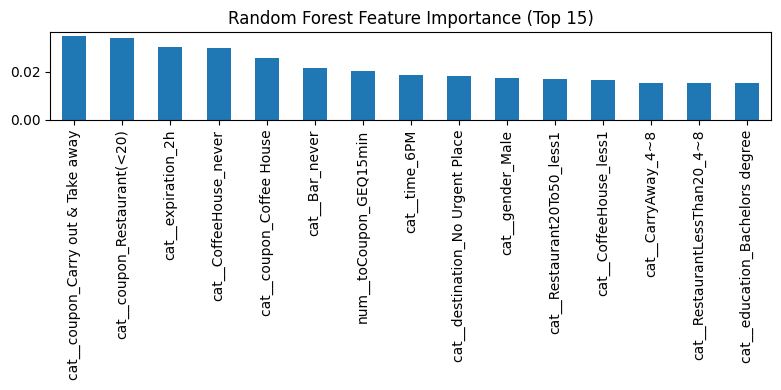

Gradient Boosting feature importance (top 20):
cat__coupon_Restaurant(<20)             0.086182
cat__coupon_Carry out & Take away       0.081534
cat__coupon_Coffee House                0.070768
cat__CoffeeHouse_never                  0.058678
cat__expiration_2h                      0.046587
cat__destination_No Urgent Place        0.028393
num__toCoupon_GEQ25min                  0.026326
cat__Bar_never                          0.026215
cat__weather_Sunny                      0.018000
cat__passanger_Friend(s)                0.017465
cat__time_10PM                          0.016336
cat__coupon_Restaurant(20-50)           0.014457
cat__Bar_less1                          0.013988
num__direction_same                     0.013671
cat__maritalStatus_Unmarried partner    0.013372
cat__gender_Male                        0.013167
cat__CarryAway_less1                    0.012629
num__toCoupon_GEQ15min                  0.012121
cat__time_6PM                           0.012018
cat__age_36           

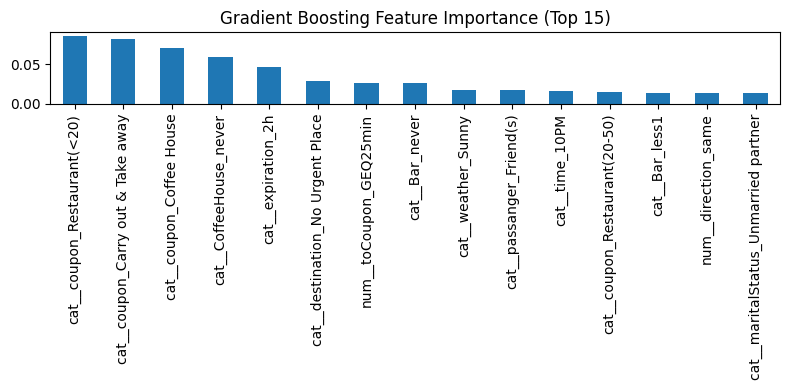

In [56]:
rf_importances = pd.Series(
    best_rf.feature_importances_,
    index=feature_names
).sort_values(ascending=False)

print("Random Forest feature importance (top 20):")
print(rf_importances.head(20))

plt.figure(figsize=(8, 4))
rf_importances.head(15).plot(kind="bar")
plt.title("Random Forest Feature Importance (Top 15)")
plt.tight_layout()
plt.show()

gb_importances = pd.Series(
    best_gb.feature_importances_,
    index=feature_names
).sort_values(ascending=False)

print("Gradient Boosting feature importance (top 20):")
print(gb_importances.head(20))

plt.figure(figsize=(8, 4))
gb_importances.head(15).plot(kind="bar")
plt.title("Gradient Boosting Feature Importance (Top 15)")
plt.tight_layout()
plt.show()
